In [1]:
# -*- coding: <utf-8> -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import sparse
import pandas as pd
import unidecode
import csv 
import io




In [2]:
train_fname = 'train.csv'
test_fname = 'test.csv'
X = []
y = []
test = []
with io.open(train_fname, encoding = 'utf-8') as f:
     for line in f: 
        line = line.replace("\\xa0", "")
        line = line.replace("\\n", "")
        line = line.lower()
        y.append(int(line[0]))
        X.append(line[5:-6])
y = np.array(y)

with io.open(test_fname, encoding = 'utf-8') as f:
     for line in f: 
        line = line.replace("\\xa0", "")
        line = line.replace("\\n", "")
        line = line.lower()
        # y.append(int(line[0]))
        test.append(line)
# y = np.array(y)
print test[0]
print('n_samples : %d' % len(X))

"""where's all the ron paul trolls, to defend thispiece of shit?"""

n_samples : 4415


In [3]:
print("Le taux de prédiction au niveau de la chance est : %s" % np.mean(y == 0))

Le taux de prédiction au niveau de la chance est : 0.694450736127


In [4]:
char_counts = np.array([len(x) for x in X]).reshape((4415, 1))


In [15]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)
X_test_counts = count_vect.transform(test)
print X_train_counts.shape
count_vect.vocabulary_.get(u'fuck')
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)
print X_train_tf.toarray().shape
print len(char_counts)
# X_train_tf = sp.sparse.hstack((X_train_tf, char_counts))

# This dataset is way to high-dimensional. Better do PCA:
pca = PCA(n_components=2050)

# Maybe some original features where good, too?
# election = SelectKBest(k=500)

# combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
combined_features = FeatureUnion([("pca", pca)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X_train_tf.toarray(), y).transform(X_train_tf.toarray())
# test_features = combined_features.transform(X_test_tf)

(4415, 16821)
(4415, 16821)
4415


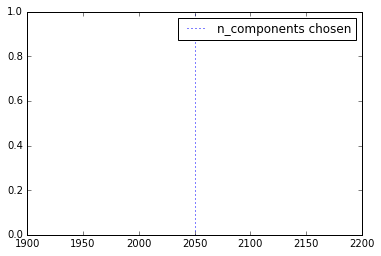

In [13]:
pca = PCA()
clf = SVC(kernel='linear', gamma=2)

pipe = Pipeline(steps=[('pca', pca), ('SVM', clf)])
n_components = np.arange(50, 3100, 200)
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(X_train_tf.toarray(), y)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [14]:
print estimator.best_estimator_

Pipeline(steps=[('pca', PCA(copy=True, n_components=2050, whiten=False)), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
clf = MultinomialNB()
print cross_val_score(clf, X_train_tf.toarray(), y)
clf = GaussianNB()
print cross_val_score(clf, X_train_tf.toarray(), y)
clf = BernoulliNB()
print cross_val_score(clf, X_train_tf.toarray(), y)

[ 0.70720109  0.69904891  0.7042828 ]
[ 0.61005435  0.61548913  0.61590755]
[ 0.7201087   0.71535326  0.72195785]


BernoulliNB seems to have the best performance.

In [28]:
for alpha in [0.4, 0.5, 0.6,0.7]:
    clf = BernoulliNB(alpha=alpha)
    print alpha
    print cross_val_score(clf, X_train_tf.toarray(), y)

0.4
[ 0.67730978  0.71467391  0.75798776]
0.5
[ 0.71671196  0.7513587   0.76682529]
0.6
[ 0.76154891  0.77377717  0.77634262]
0.7
[ 0.76902174  0.7642663   0.76002719]


set alpha = 0.6

In [34]:
from sklearn.linear_model import LogisticRegression
param_grid = {'penalty' : ['l1', 'l2'],'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clf = LogisticRegression()
estimator = GridSearchCV(clf, param_grid)
estimator.fit(X_train_tf.toarray(), y)
print estimator.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [38]:
clf1 = estimator.best_estimator_

print cross_val_score(clf, X_train_tf.toarray(), y)

AttributeError: 'list' object has no attribute 'fit'

In [41]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
print cross_val_score(clf, char_counts, y)

[ 0.65964674  0.65625     0.66349422]


In [40]:
clf1 = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf2 = SVC(kernel='linear', gamma=2)
clf3 = BernoulliNB(alpha=alpha)
from sklearn.ensemble import VotingClassifier
clf = VotingClassifier(estimators=[('LR', clf1), ('SVM', clf2), ('NAIVE B', clf3)], voting='hard')
print cross_val_score(clf, X_train_tf, y)

[ 0.79755435  0.80027174  0.80557444]


In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
clf = AdaBoostClassifier([SVC(kernel='linear', gamma=2),estimator.best_estimator_] ,algorithm="SAMME",n_estimators=100)
print cross_val_score(clf, X_features, y)

AttributeError: 'list' object has no attribute 'fit'

In [24]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', gamma=2, class_weight = {0:1, 1:2})
clf.fit(X_features, y)
y_pre = clf.predict(test_features)
np.savetxt('y_pred.txt', y_pre, fmt='%s')

In [9]:
from sklearn.cross_validation import cross_val_score

# from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
for kernel in ('linear', 'poly', 'rbf'):
    clf = SVC(kernel=kernel, gamma=10)
# clf = SVC()
    print "kernel : ", kernel
    print cross_val_score(clf, X_features, y)

kernel :  linear
[ 0.80095109  0.80163043  0.82053025]
kernel :  poly
[ 0.76290761  0.77649457  0.76342624]
kernel :  rbf
[ 0.70244565  0.7017663   0.70156356]


In [4]:
wordContent = []
wordCount = dict()
import re
regEx = re.compile('\\W*') # match any ~[A-Z0-9]
for x in X:
    for word in regEx.split(x):
        if word in wordCount.keys():
            wordCount[word] = wordCount[word] + 1
        else:
            wordCount[word] = 1



In [5]:
stopList = set()
with io.open('stop_word.txt', newline = '\n') as f:
     for line in f: 
        line = line.strip()
        stopList.add(line)
print stopList

set([u'all', u"she'll", u"don't", u'being', u'over', u'through', u'yourselves', u'its', u'before', u"he's", u"when's", u"we've", u'had', u'should', u"he'd", u'to', u'only', u"there's", u'those', u'under', u'has', u"haven't", u'do', u'them', u'his', u"they'll", u'very', u"who's", u"they'd", u'cannot', u"you've", u'they', u'not', u'during', u'yourself', u'him', u'nor', u"we'll", u'did', u"they've", u'this', u'she', u'each', u"won't", u'where', u"mustn't", u"isn't", u"i'll", u"why's", u'because', u"you'd", u'doing', u'some', u'up', u'are', u'further', u'out', u'what', u'for', u'while', u"wasn't", u'does', u"shouldn't", u'above', u'between', u'be', u'we', u'who', u"you're", u'were', u'here', u'hers', u"aren't", u'by', u'both', u'about', u'would', u'of', u'could', u'against', u"i'd", u"weren't", u"i'm", u'or', u"can't", u'own', u'into', u'whom', u'down', u"hadn't", u"couldn't", u'your', u"doesn't", u'from', u"how's", u'her', u'their', u"it's", u'there', u'been', u'why', u'few', u'too', u'th

In [6]:
def filtre(wordCount, cirtere, stopList):
    wordList = []
    for key, value in wordCount.iteritems():
        if key not in stopList and value > cirtere:
            wordList.append(key)
    return wordList
            
        
    
def words2Vectors(wordList, data):
    vec = [0] * len(wordList)
    for word in data:
        if word in wordList:
            vec[wordList.index(word)] = vec[wordList.index(word)] + 1 // +1
    return vec

def createWordList(wordContent):
    # no word occur twice
    wordSet = set()
    for word in wordContent:
        if word not in wordSet:
            wordSet.add(word)
    return list(wordSet)

In [7]:
wordList  = createWordList(wordContent)

In [8]:
wordList = filtre(wordCount, 2, stopList)
vectors = []
for x in X:
    vectors.append(words2Vectors(wordList, x))

KeyboardInterrupt: 

In [ ]:
with open('vectors.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerows(vectors)

In [ ]:
print wordList